In [1]:
import pandas as pd
import os

image_dir = "koniq10k_512x384"
image_files = [
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
print(f"Processing {len(image_files)} images")

Processing 10373 images


In [2]:
# Extract simplified features (only 6 key features)
from features import build_features, feature_names

print("Extracting simplified features:", feature_names)
df_features = build_features(image_dir, out_csv="features.csv")
print(f"Features extracted: {df_features.shape}")
print("\nFirst few rows:")
print(df_features.head())

Extracting simplified features: ['brightness', 'contrast', 'colorfulness', 'sharpness', 'saturation', 'texture_noise']


Features: 100%|██████████| 10373/10373 [02:03<00:00, 83.66it/s]

Features extracted: (10373, 7)

First few rows:
   brightness  contrast  colorfulness    sharpness  saturation  texture_noise  \
0    0.391834  0.285977      0.205167  5882.530762    0.352884       0.033003   
1    0.640100  0.189211      0.087098  1700.044434    0.176919       0.028776   
2    0.515108  0.205691      0.256794  3313.512939    0.376071       0.004739   
3    0.147618  0.131045      0.092469   549.194153    0.505630       0.005143   
4    0.739071  0.157133      0.182636  3783.313232    0.278414       0.007227   

        image_path  
0  10004473376.jpg  
1  10007357496.jpg  
2  10007903636.jpg  
3  10009096245.jpg  
4    100117038.jpg  


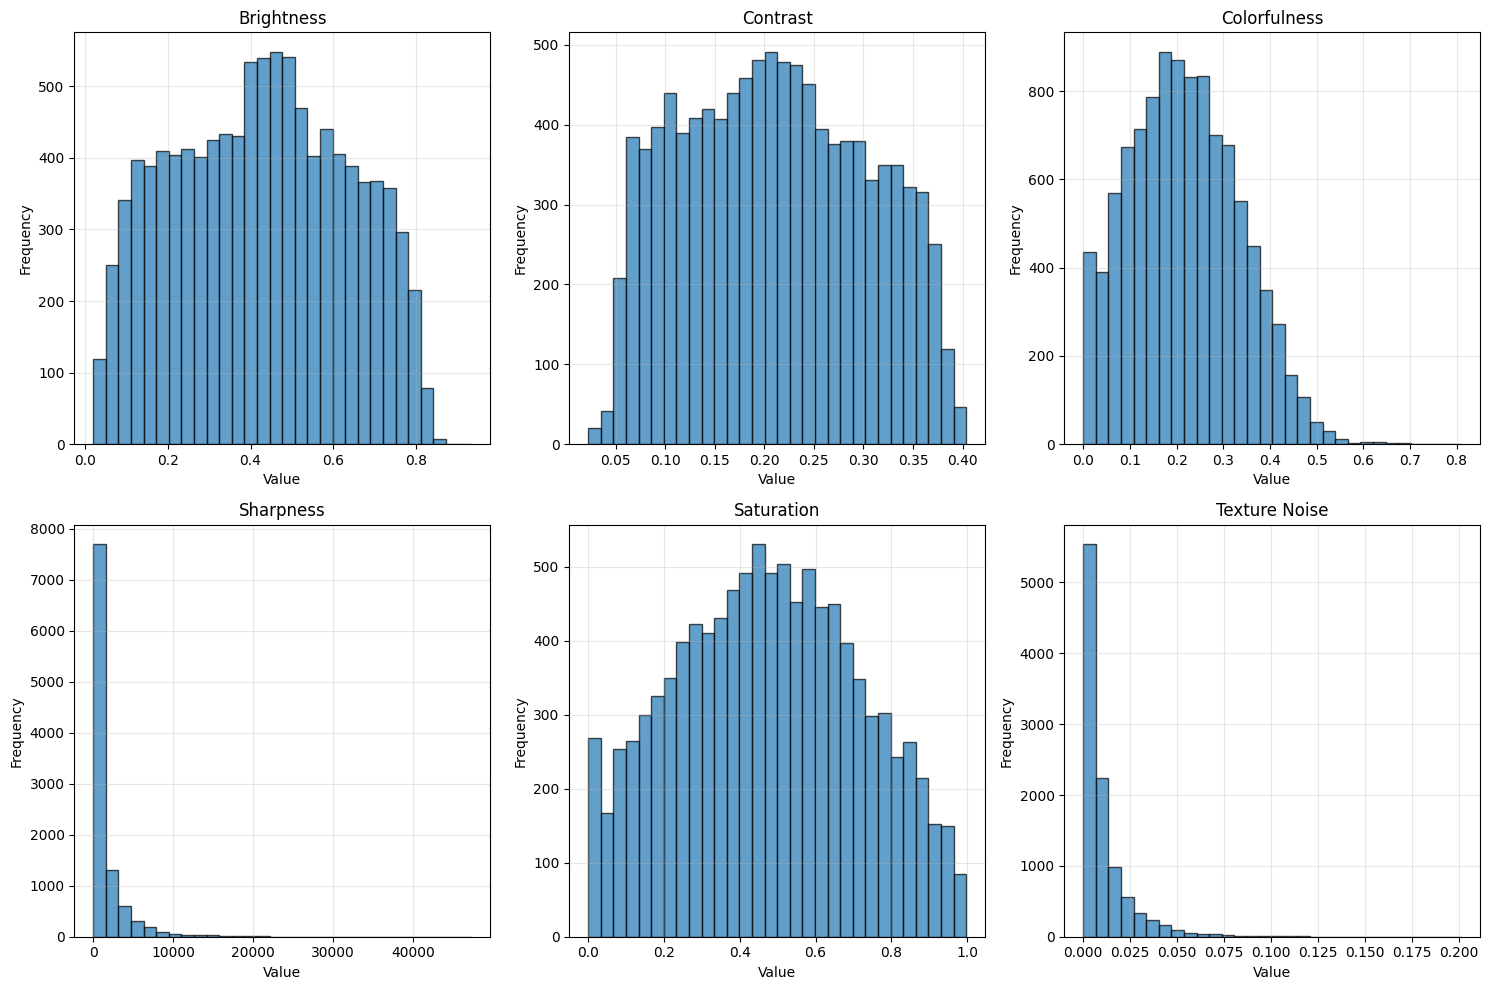


Feature Summary Statistics:
         brightness      contrast  colorfulness     sharpness    saturation  \
count  10373.000000  10373.000000  10373.000000  10373.000000  10373.000000   
mean       0.425305      0.210927      0.217183   1435.757690      0.473766   
std        0.206717      0.091523      0.117020   2431.007324      0.241583   
min        0.020846      0.022494      0.000000      5.467133      0.000000   
25%        0.253842      0.134821      0.128118    130.926254      0.287449   
50%        0.430513      0.208624      0.211203    503.115936      0.472462   
75%        0.590720      0.284841      0.299793   1653.964966      0.654508   
max        0.931918      0.403485      0.809616  47274.433594      0.997313   

       texture_noise  
count   10373.000000  
mean        0.011301  
std         0.014171  
min         0.000000  
25%         0.003205  
50%         0.006117  
75%         0.013418  
max         0.201301  


In [ ]:
# Display feature statistics
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    axes[i].hist(df_features[feature], bins=30, alpha=0.7, edgecolor="black")
    axes[i].set_title(f'{feature.replace("_", " ").title()}')
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFeature Summary Statistics:")
print(df_features[feature_names].describe())

In [ ]:
from scoring import compute_all_scores

compute_all_scores("koniq10k_512x384")

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
import json

df_scores = pd.read_csv("iqa_raw_scores.csv")
df_mos = pd.read_csv("koniq10k_scores_and_distributions.csv")
df_features = pd.read_csv("features.csv")

if "image_name" not in df_scores.columns:
    df_scores.columns = ["image_name"] + list(df_scores.columns[1:])

df = df_scores.merge(df_mos[["image_name", "MOS"]], on="image_name")
df = df.merge(df_features, left_on="image_name", right_on="image_path")

iqa_methods = ["brisque", "niqe", "piqe", "maniqa", "hyperiqa"]
mos_predictions = {}
regression_coefficients = {}

for method in iqa_methods:
    reg = LinearRegression()
    X = df[[method]].values
    y = df["MOS"].values
    reg.fit(X, y)
    mos_predictions[f"{method}_mos"] = reg.predict(X)
    regression_coefficients[method] = {
        "coef": float(reg.coef_[0]),
        "intercept": float(reg.intercept_),
    }
    print(f"{method}: R²={reg.score(X, y):.4f}")

with open("mos_mapping_coefficients.json", "w") as f:
    json.dump(regression_coefficients, f, indent=2)

errors = {
    method: np.abs(mos_predictions[f"{method}_mos"] - df["MOS"].values)
    for method in iqa_methods
}
errors_df = pd.DataFrame(errors)
df["best_method"] = errors_df.idxmin(axis=1)
df["best_method_label"] = df["best_method"].map(
    {m: i for i, m in enumerate(iqa_methods)}
)
df["best_method_error"] = errors_df.min(axis=1)

print(f"\n{df['best_method'].value_counts()}")
df.to_csv("router_training_data.csv", index=False)
print(f"Dataset: {df.shape}")

brisque: R²=0.0487
niqe: R²=0.0832
piqe: R²=0.0177
maniqa: R²=0.8609
hyperiqa: R²=0.9099

best_method
hyperiqa    4978
maniqa      3256
niqe         650
piqe         626
brisque      563
Name: count, dtype: int64
Dataset: (10073, 17)


Training with simplified features: ['brightness', 'contrast', 'colorfulness', 'sharpness', 'saturation', 'texture_noise']
Training data shape: (10073, 6)
Feature names: ['brightness', 'contrast', 'colorfulness', 'sharpness', 'saturation', 'texture_noise']
Training Accuracy: 0.8465
Training Accuracy: 0.8465


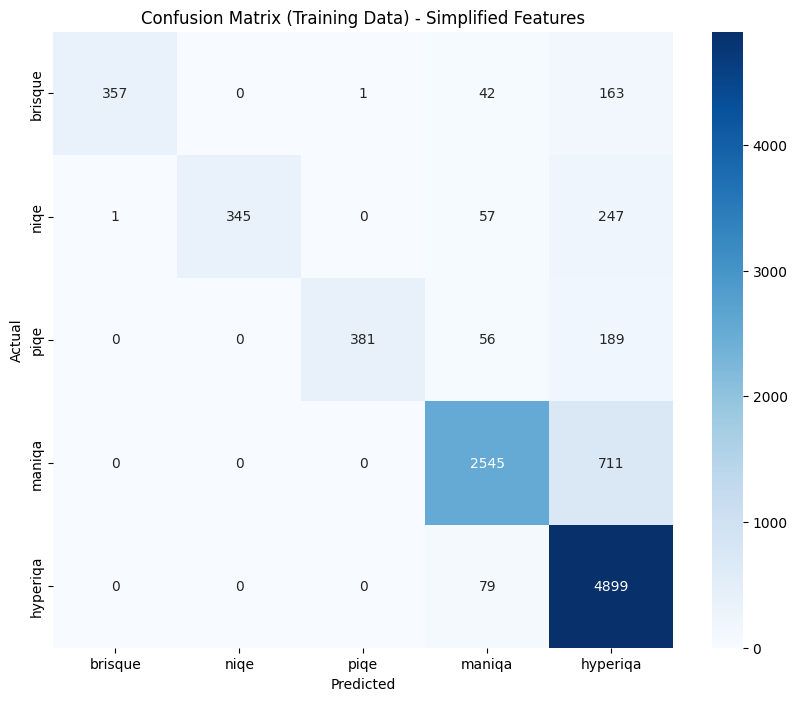


✓ Router trained with simplified features and saved!


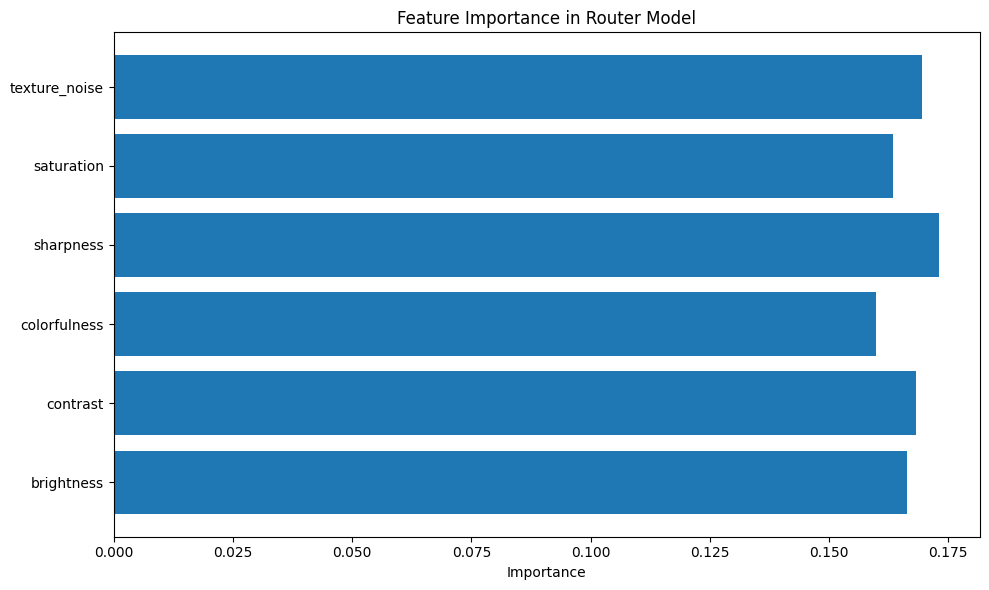

1. Brightness: 0.1664
2. Contrast: 0.1681
3. Colorfulness: 0.1598
4. Sharpness: 0.1730
5. Saturation: 0.1633
6. Texture Noise: 0.1694


In [5]:
# Train router using simplified features
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv("router_training_data.csv")
print(f"Training with simplified features: {feature_names}")

# Use only the 6 simplified features
X = df[feature_names].values
y = df["best_method_label"].values

print(f"Training data shape: {X.shape}")
print(f"Feature names: {feature_names}")

# Train on ALL data (no split - you'll test on separate dataset later)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

router = XGBClassifier(n_estimators=100, random_state=42)
router.fit(X_scaled, y, verbose=50)

# Training performance
y_pred = router.predict(X_scaled)
print(f"Training Accuracy: {np.mean(y_pred == y):.4f}")

# Confusion matrix on training data
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=iqa_methods,
    yticklabels=iqa_methods,
)
plt.title("Confusion Matrix (Training Data) - Simplified Features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save router and scaler
router.save_model("router_xgb.json")
joblib.dump(scaler, "scaler.pkl")
print("\n✓ Router trained with simplified features and saved!")

# Display feature importance
feature_importance = router.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title("Feature Importance in Router Model")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

for i, (feature, importance) in enumerate(zip(feature_names, feature_importance)):
    print(f"{i+1}. {feature.replace('_', ' ').title()}: {importance:.4f}")

In [6]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from router import predict

# Use same test split for evaluation (even though router trained on all data)
df_full = pd.read_csv("router_training_data.csv")
_, test_df = train_test_split(
    df_full, test_size=0.2, random_state=42, stratify=df_full["best_method_label"]
)

# Adaptive routing predictions
predictions, confidences, selected_methods, times = [], [], [], []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    try:
        result = predict(f"koniq10k_512x384/{row['image_name']}")
        predictions.append(result["MOS_estimate"])
        confidences.append(result["confidence"])
        selected_methods.append(result["selected_method"])
        times.append(result["timing"]["total_time_ms"])
    except Exception as e:
        print(f"Error: {e}")

ground_truth = test_df["MOS"].values[: len(predictions)]

# Compute metrics
srocc = spearmanr(predictions, ground_truth)[0]
plcc = pearsonr(predictions, ground_truth)[0]
rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
mae = mean_absolute_error(ground_truth, predictions)

print(f"\n{'='*60}")
print(f"ADAPTIVE ROUTING PERFORMANCE")
print(f"{'='*60}")
print(f"SROCC: {srocc:.4f}")
print(f"PLCC:  {plcc:.4f}")
print(f"RMSE:  {rmse:.4f}")
print(f"MAE:   {mae:.4f}")
print(f"Avg Time: {np.mean(times):.2f}ms")
print(f"{'='*60}")

# Method usage statistics
from collections import Counter

method_counts = Counter(selected_methods)
print(f"\nMethod Selection Distribution:")
for method, count in method_counts.most_common():
    print(f"  {method}: {count} ({count/len(selected_methods)*100:.1f}%)")

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(
    ground_truth, predictions, alpha=0.5, s=30, edgecolors="black", linewidths=0.5
)
plt.plot([1, 5], [1, 5], "r--", linewidth=2, label="Perfect")
plt.xlabel("Ground Truth MOS")
plt.ylabel("Predicted MOS")
plt.title(f"Adaptive Routing\nSROCC={srocc:.4f}, PLCC={plcc:.4f}, RMSE={rmse:.4f}")
plt.legend()
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save detailed results
pd.DataFrame(
    {
        "image_name": test_df["image_name"].values[: len(predictions)],
        "ground_truth": ground_truth,
        "predicted": predictions,
        "method": selected_methods,
        "confidence": confidences,
        "time_ms": times,
        "error": np.abs(predictions - ground_truth),
    }
).to_csv("evaluation_results.csv", index=False)

print("\n✓ Evaluation complete! Results saved to 'evaluation_results.csv'")

d:\Github\NR-IQA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/2015 [00:00<?, ?it/s]d:\Github\NR-IQA\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
d:\Github\NR-IQA\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading pretrained model MANIQA from C:\Users\aryam\.cache\torch\hub\pyiqa\ckpt_koniq10k.pt


  0%|          | 0/2015 [00:12<?, ?it/s]



KeyboardInterrupt: 

In [ ]:
def assess_image(image_path):
    """
    Quick image quality assessment using simplified features and adaptive routing.
    Uses only 6 key features: brightness, contrast, colorfulness, sharpness, saturation, texture/noise.
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    result = predict(image_path)

    print(f"Image: {os.path.basename(image_path)}")
    print(f"MOS: {result['MOS_estimate']:.3f}/5.0")
    print(
        f"Method: {result['selected_method']} (confidence: {result['confidence']:.3f})"
    )
    print(f"Time: {result['timing']['total_time_ms']:.2f}ms")

    # Show the extracted features for this image
    from features import extract_features

    features = extract_features(image_path)
    print(f"\nExtracted Features:")
    for i, (name, value) in enumerate(zip(feature_names, features)):
        print(f"  {i+1}. {name.replace('_', ' ').title()}: {value:.4f}")

    return result


# Example usage with the simplified feature set
print("=== Simplified NR-IQA Assessment ===")
print(f"Using {len(feature_names)} simplified features: {', '.join(feature_names)}")
print()
r = assess_image("me at night.jpg")

=== Simplified NR-IQA Assessment ===
Using 6 simplified features: brightness, contrast, colorfulness, sharpness, saturation, texture_noise

Image: me at night.jpg
MOS: 2.227/5.0
Method: hyperiqa (confidence: 0.494)
Time: 1014.07ms

Extracted Features:
  1. Brightness: 0.4667
  2. Contrast: 0.2300
  3. Colorfulness: 0.1075
  4. Sharpness: 432.3902
  5. Saturation: 0.1890
  6. Texture Noise: 0.0045
Image: me at night.jpg
MOS: 2.227/5.0
Method: hyperiqa (confidence: 0.494)
Time: 1014.07ms

Extracted Features:
  1. Brightness: 0.4667
  2. Contrast: 0.2300
  3. Colorfulness: 0.1075
  4. Sharpness: 432.3902
  5. Saturation: 0.1890
  6. Texture Noise: 0.0045
